In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd


class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.G[i,0], self.G[i,1]
                plt.text(x, y, t, va='center', ha='center', color='b')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.G[:, 0], self.G[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

    def scree_diagram(self, perc=True, *args, **kwargs):
        """Plot the scree diagram."""
        eigenvals = self.eigenvals
        xs = np.arange(1, eigenvals.size + 1, 1)
        ys = 100. * eigenvals / eigenvals.sum() if perc else eigenvals
        plt.plot(xs, ys, *args, **kwargs)
        plt.xlabel('Dimension')
        plt.ylabel('Eigenvalue' + (' [%]' if perc else ''))



In [4]:
import pandas as pd

In [6]:
df = pd.read_csv('house_prices_fixed.csv',decimal=',')

In [7]:
df.describe()

,area,demanded_price,final_price,monthly_fee,operating_cost,price_per_squaremeter,year_of_construction
count,236.000000,2.360000e+02,2.360000e+02,236.000000,205.000000,236.000000,236.000000
mean,51.313559,3.918665e+06,4.255023e+06,3031.029661,5364.853659,83405.406780,1959.559322
std,21.914320,1.990376e+06,2.020610e+06,1143.708769,1763.301268,11409.892666,32.012376
min,19.000000,1.795000e+06,2.000000e+06,1217.000000,1100.000000,56875.000000,1909.000000
25%,35.000000,2.595000e+06,2.875000e+06,2123.500000,4056.000000,75826.000000,1938.000000
50%,44.500000,3.075000e+06,3.425000e+06,2797.000000,5200.000000,81936.500000,1939.000000
75%,64.125000,4.708750e+06,5.162500e+06,3727.000000,6144.000000,90828.000000,2004.000000
max,135.000000,1.395000e+07,1.500000e+07,7368.000000,12979.000000,127727.000000,2007.000000


In [8]:
df.head()

,address,area,date,demanded_price,final_price,monthly_fee,operating_cost,price_per_squaremeter,room_number,title,url,year_of_construction
0,Luxgatan 7,30.0,13/01/21,2350000,2550000,1733,6096.0,85000,1 rum,Luxgatan 7 - Sald - Lilla Essingen \\\\ Kungs...,https://www.hemnet.se/salda/lagenhet-1rum-lill...,1937
1,"Primusgatan 108, 6/6 tr",101.0,10/01/21,11400000,11400000,5887,5540.0,112871,4 rum,"Primusgatan 108, 6/6 tr - Sald - Kungsholmen ...",https://www.hemnet.se/salda/lagenhet-4rum-kung...,1935
2,"Stralgatan 47, 3 tr",31.0,08/01/21,2595000,2875000,2471,3200.0,92742,2 rum,"Stralgatan 47, 3 tr - Sald - Lilla Essingen ...",https://www.hemnet.se/salda/lagenhet-2rum-lill...,1939
3,Disponentgatan 1,46.0,08/01/21,3550000,3550000,3003,12979.0,77174,"2,5 rum","Disponentgatan 1 - Sald - Lilla Essingen, STO...","https://www.hemnet.se/salda/lagenhet-2,5rum-li...",1935
4,Essinge Brogata 12,34.5,08/01/21,2495000,2900000,2162,4200.0,84058,2 rum,Essinge Brogata 12 - Sald - Kungsholmen - Lil...,https://www.hemnet.se/salda/lagenhet-2rum-kung...,1934


## Room number - Price Category

In [14]:
data['price_category'] = list(map(lambda x: 'expensive' if x > 83405 else 'cheap',data['price_per_squaremeter']))

In [20]:
contigency_pct = pd.crosstab(data['room_number'],  data['price_category'])

In [21]:
contigency_pct

price_category,cheap,expensive
room_number,,
1 rum,4,25
"1,5 rum",5,11
2 rum,85,43
"2,5 rum",5,1
3 rum,28,15
"3,5 rum",3,0
4 rum,3,8


In [22]:
ca = CA(contigency_pct)

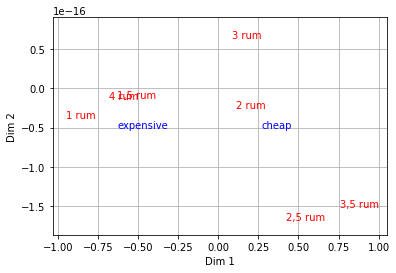

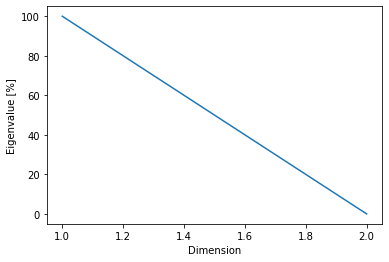

In [23]:
plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()

Since 1, 1.5 and 4 rooms apartment are rare, their price is closer 

## Test - Build year - Price 

In [25]:
data['years_category'] = list(map(lambda x: 'new' if x > 1960 else 'old',data['year_of_construction']))

In [27]:
data_crosstab = pd.crosstab(data['years_category'], data['price_category'])

In [28]:
data_crosstab

price_category,cheap,expensive
years_category,,
new,50,28
old,83,75


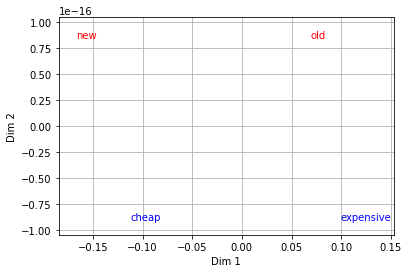

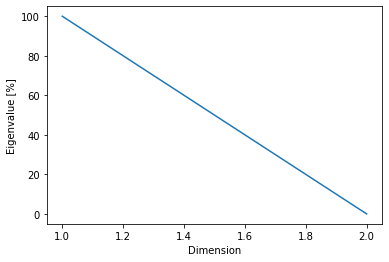

In [30]:
ca = CA(data_crosstab)
plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()

## Test -Area - Price

In [32]:
data['area_category'] = list(map(lambda x: 
                                  'very big' if x > 64.125 else (
                                  'big' if x > 44.50 else (
                                  'average' if x > 35 else 
                                      'small'))
                                  ,data['area']))

In [33]:
data_crosstab = pd.crosstab(data['area_category'], data['price_category'])

In [34]:
data_crosstab

price_category,cheap,expensive
area_category,,
average,42,15
big,42,16
small,14,48
very big,35,24


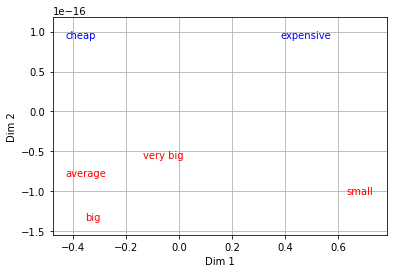

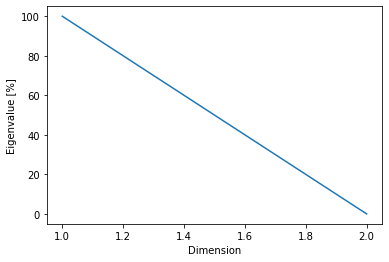

In [35]:
ca = CA(data_crosstab)
plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()

## Test - Street - Price

In [36]:
data['street'] = list(map(lambda x: x.split()[0],data['address']))

In [37]:
data['street'] = list(map(lambda x: 'Essinge Brogata' if x == 'Essinge' else x,data['street']))

In [38]:
data_crosstab = pd.crosstab(data['street'],  data['price_category'])

In [39]:
data_crosstab

price_category,cheap,expensive
street,,
Disponentgatan,7,5
Essinge Brogata,41,24
Luxgatan,15,17
Patentgatan,1,2
Primusgatan,37,29
Stralgatan,32,26


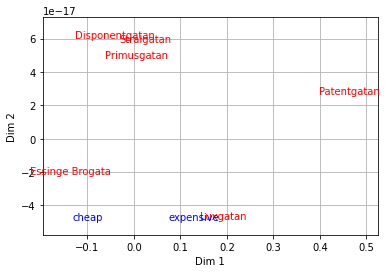

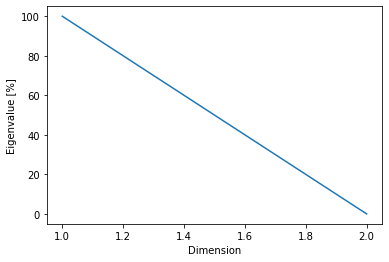

In [40]:
ca = CA(data_crosstab)
plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()